In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statistics import mean, stdev

In [2]:
df = pd.read_csv("scCO2_alvaDesc_full.csv")

In [3]:
X=df.drop(['SMILES', "MOLECULEID", "Solubility"], axis=1)

In [4]:
y = df['Solubility']
y = y.astype(float)

In [5]:
rmse_scores = []
r2_scores = []
mae_scores = []
average_relative_deviations = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    model = catboost.CatBoostRegressor(silent=True) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    Y_pred_array = np.array(y_pred)
    Y_true_array = np.array(y_test)

    relative_deviation = (Y_true_array - Y_pred_array) / Y_true_array
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean()*100
    average_relative_deviations.append(average_relative_deviation)
    
    print(f"Iteration {i}: R2 = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}, AARD = {average_relative_deviation:.3f}")

Iteration 0: R2 = 0.987, RMSE = 0.134, MAE = 0.079, AARD = 1.890
Iteration 1: R2 = 0.988, RMSE = 0.124, MAE = 0.073, AARD = 1.819
Iteration 2: R2 = 0.989, RMSE = 0.119, MAE = 0.076, AARD = 1.747
Iteration 3: R2 = 0.988, RMSE = 0.123, MAE = 0.074, AARD = 1.760
Iteration 4: R2 = 0.991, RMSE = 0.108, MAE = 0.072, AARD = 1.739


In [6]:
print("\nAverage performance of test set at 5 split")
print("Metric\tavg\tstdev")
print("R^2\t%.3f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
print("RMSE\t%.3f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))
print("MAE\t%.3f\t%.2f" % (mean(mae_scores), stdev(mae_scores)))
print("AARD\t%.3f\t%.2f" % (mean(average_relative_deviations), stdev(average_relative_deviations)))


Average performance of test set at 5 split
Metric	avg	stdev
R^2	0.989	0.00
RMSE	0.122	0.01
MAE	0.075	0.00
AARD	1.791	0.06


In [7]:
# Statistics for the training set with 5CV
r2_scores = []
rmse_scores = []
mae_scores = []
average_relative_deviations = []

for i in range(5):
    X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
    X_tr.reset_index(drop=True , inplace=True)
    y_tr.reset_index(drop=True , inplace=True)
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    y_pred, y_true = [], []
    for train_index, test_index in cv.split(X_tr):
        X_train = X_tr.loc[train_index].values
        X_test = X_tr.loc[test_index].values
        y_train = y_tr.loc[train_index].values
        y_test = y_tr.loc[test_index].values

        model = catboost.CatBoostRegressor(silent=True)
        model.fit(X_train, y_train)
        y_pred.extend(model.predict(X_test))
        y_true.extend(y_test)

    r2_scores.append(metrics.r2_score(y_true, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_true, y_pred, squared=False))
    mae_scores.append(metrics.mean_absolute_error(y_true, y_pred))
    Y_pred_array = np.array(y_pred)
    Y_true_array = np.array(y_true)

    relative_deviation = (Y_true_array - Y_pred_array) / Y_true_array
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean()*100
    average_relative_deviations.append(average_relative_deviation)
    

In [8]:
print("\nAverage performance of training set with 5CV at 5 split")
print("Metric\tavg\tstdev")
print("R^2\t%.3f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
print("RMSE\t%.3f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))
print("MAE\t%.3f\t%.2f" % (mean(mae_scores), stdev(mae_scores)))
print("AARD\t%.3f\t%.2f" % (mean(average_relative_deviations), stdev(average_relative_deviations)))


Average performance of training set with 5CV at 5 split
Metric	avg	stdev
R^2	0.988	0.00
RMSE	0.126	0.00
MAE	0.080	0.00
AARD	1.877	0.04


In [9]:
#Final model

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

In [11]:
Y_pred, Y_true = [], []
average_relative_deviations = []
for train_index, test_index in cv.split(X):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    rf = CatBoostRegressor(silent=True)
    rf.fit(x_train, y_train)
    Y_pred.extend(rf.predict(x_test))
    Y_true.extend(y_test)
    
    Y_pred_array = np.array(Y_pred)
    Y_true_array = np.array(Y_true)

    relative_deviation = (Y_true_array - Y_pred_array) / Y_true_array
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean()*100
    average_relative_deviations.append(average_relative_deviation)
    
print('R^2 = {}'.format(round(metrics.r2_score(Y_true, Y_pred),3)))
print('RMSE = {}'.format(round(metrics.mean_squared_error(Y_true, Y_pred, squared=False),3)))
print('MAE = {}'.format(round(mean_absolute_error(Y_true, Y_pred),3)))
print('AARD =', round(sum(average_relative_deviations) / len(average_relative_deviations), 3))

R^2 = 0.989
RMSE = 0.121
MAE = 0.074
AARD = 1.771


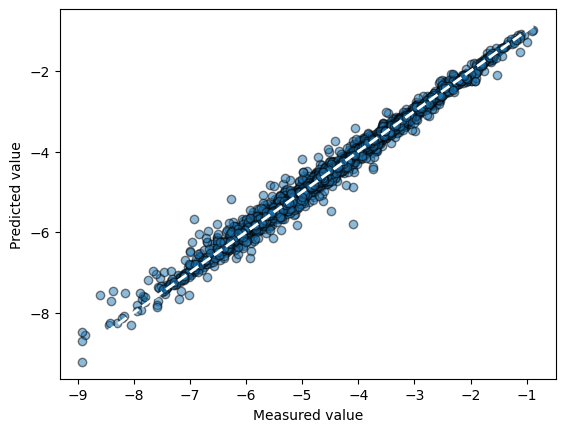

In [12]:
fig, ax = plt.subplots()
ax.scatter(Y_true, Y_pred, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], "w--", lw=2)
ax.set_xlabel("Measured value")
ax.set_ylabel("Predicted value")
plt.show()